In [3]:
def get_full_uspcm_dict():
    """Access the GitHub repo to put together the complete uspcm_dict,
the dictionary of connected graphs on up to 10 vertices (inclusive) with the spectator number for each graph.

This is a nested dictionary, to access, e.g., the dictionary of connected graphs on 6 vertices and 10 edges, use
uspcm_dict['6_verts']['10_edges']. The innermost dictionary's keys are graph6_strings and the values are the spectator
number for that graph."""
    
    import requests

    uspcm_dict = {}
    url_path = 'https://raw.githubusercontent.com/cerickson30/qBound/main/data/uspcm_dict/'


    for num_verts in range(2):
        uspcm_dict[f'{num_verts}_verts'] = {}

        filename = f'uspcm_dict_{num_verts}_verts_{0}_edges.txt'

        file_url = f'{url_path}/{filename}'
        response = response = requests.get(file_url)
        uspcm_dict[f'{num_verts}_verts'][f'{0}_edges'] = eval(response.text)


    for num_verts in range(2, 11):
        uspcm_dict[f'{num_verts}_verts'] = {}

        for num_edges in range(num_verts*(num_verts-1)//2, 0, -1):
            filename = f'uspcm_dict_{num_verts}_verts_{num_edges}_edges.txt'

            file_url = f'{url_path}/{filename}'
            response = response = requests.get(file_url)
            uspcm_dict[f'{num_verts}_verts'][f'{num_edges}_edges'] = eval(response.text)
            
    return uspcm_dict



def get_partial_uspcm_dict(num_verts, num_edges):
    """Access the GitHub repo to get just the part of the uspcm_dict for num_verts vertices and num_edges edges,
    where num_verts is at most 10.

This is a nested dictionary, to access, e.g., the dictionary of connected graphs on 6 vertices and 10 edges, use
uspcm_dict['6_verts']['10_edges']. The innermost dictionary's keys are graph6_strings and the values are the spectator
number for that graph."""
    
    import requests

    uspcm_dict = {}
    url_path = 'https://raw.githubusercontent.com/cerickson30/qBound/main/data/uspcm_dict/'
    filename = f'uspcm_dict_{num_verts}_verts_{num_edges}_edges.txt'

    file_url = f'{url_path}/{filename}'
    response = response = requests.get(file_url)
    
    uspcm_dict[f'{num_verts}_verts'] = {}
    uspcm_dict[f'{num_verts}_verts'][f'{num_edges}_edges'] = eval(response.text)

    return uspcm_dict



def read_minor_minimals():
    """Returns the dictionary of spectator number minor-minimal graphs from the GitHub repo"""
    import requests
    
    url = 'https://raw.githubusercontent.com/cerickson30/qBound/main/data/minimals_dict.txt'
    response = requests.get(url)
    return eval(response.text)

In [2]:
get_full_uspcm_dict?

Signature:      get_full_uspcm_dict()
Docstring:     
Access the GitHub repo to put together the complete uspcm_dict, the
dictionary of connected graphs on up to 10 vertices (inclusive) with
the spectator number for each graph.

This is a nested dictionary, to access, e.g., the dictionary of
connected graphs on 6 vertices and 10 edges, use
uspcm_dict['6_verts']['10_edges']. The innermost dictionary's keys are
graph6_strings and the values are the spectator number for that graph.
Init docstring: Initialize self.  See help(type(self)) for accurate signature.
File:           ~/Projects/MRC_Haystacks/qBound/qBound_for_github/<ipython-input-1-63ac56b5f6ce>
Type:           function


In [3]:
with open('data/full_uspcm_dict/full_uspcm_dict.txt') as infile:
    uspcm_dict = eval(infile.read())

IheA@GUAo


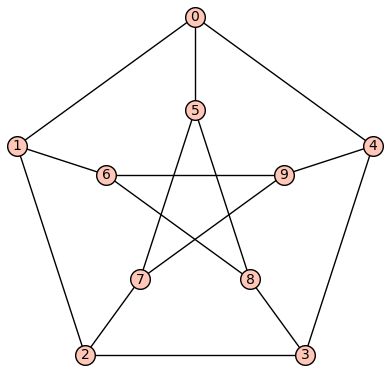

In [4]:
G = graphs.PetersenGraph()

print(G.graph6_string())

G.show()

I@OZCMgs?


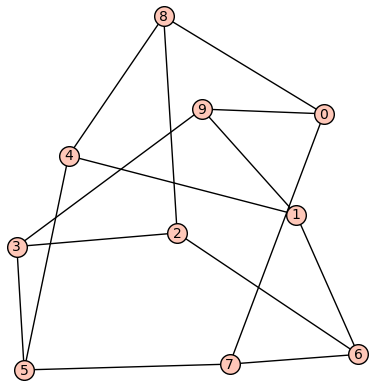

7

In [6]:
graph_str = 'IheA@GUAo'

G = Graph(graph_str).canonical_label()
g6_str = G.graph6_string()

print(g6_str)
G.show()

num_verts = G.num_verts()
num_edges = G.num_edges()

uspcm_dict[f'{num_verts}_verts'][f'{num_edges}_edges'][g6_str]

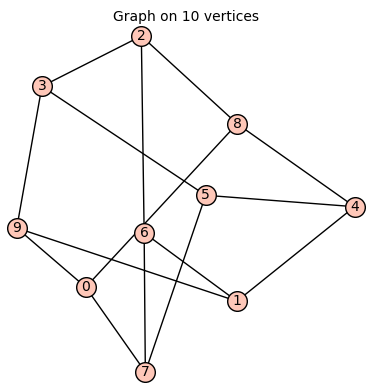

In [7]:
G.canonical_label()

In [8]:
G.graph6_string()

'I@OZCMgs?'

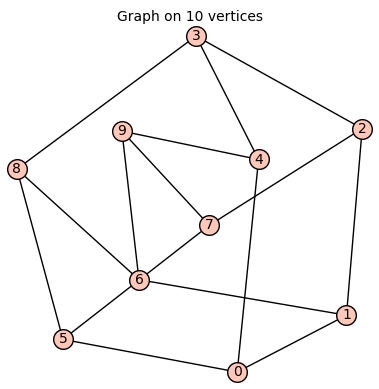

In [9]:
Graph('IheA@GUAo')

In [16]:
%%cython
import gc
gc.enable()


def usp_comp(amat):
    """ Return the size of the smallest unique-shortest-path complement of a graph.
    """
    # Accept graph or matrix input
    
    try:
        nn = amat.ncols()
    except AttributeError:
        amat = amat.adjacency_matrix()
        nn = amat.ncols()
    if not amat:
        return nn - 1
    A = amat + 2
    AA = A + 0
    compsize = nn - 1
    while min(min([yy for yy in xx if yy]) for xx in AA) == 1:
        compsize -= 1
        AA = AA*A
    
    return compsize



def Glabel(G):
    return G.canonical_label().graph6_string()

def edgeclasses(G):
    Aut = G.automorphism_group()
    needs = {(xx[0], xx[1]): True for xx in G.edges()}
    while needs:
        anedge = next(iter(needs))
        yield anedge
        for xx in Aut.orbit(anedge, action='OnPairs'):
            if (xx[0], xx[1]) in needs:
                del needs[(xx[0], xx[1])]
            if (xx[1], xx[0]) in needs:
                del needs[(xx[1], xx[0])]

def deletions(G):
    for ed in edgeclasses(G):
        H = G.copy()
        H.delete_edge(ed)
        yield Glabel(H)

def contractions(G):
    # Also covers isolated vertex deletion
    for ed in edgeclasses(G):
        H = G.copy()
        H.contract_edge(ed)
        yield Glabel(H)
    if 0 in G.degree():
        H = G.copy()
        H.delete_vertex(G.degree().index(0))
        yield Glabel(H)

In [23]:
def check_minimality(graph_str, uspcm_dict):
    """INPUT: graph: A graph, graph6_string, or adjacency matrix for a connected graph on at most 10 vertices
uspcm_dict: A dictionary of spectator floor numbers, either the complete dictionary or partial dictionary with
the spectator floor numbers for graphs on the number of vertices and edges that the graph argument has.
OUTPUT: Prints the spectator floor of the graph and the spectator floor of each contraction and deletion.
    """
    G = Graph(graph_str).canonical_label()
    g6_str = G.graph6_string()
    
    G_num_verts = G.num_verts()
    G_num_edges = G.num_edges()
    G_spec_num = uspcm_dict[f'{G_num_verts}_verts'][f'{G_num_edges}_edges'][g6_str]
    
    for xx in deletions(G):
        xx_num_verts = Graph(xx).num_verts()
        xx_num_edges = Graph(xx).num_edges()

        xx_spec_num = uspcm_dict[f'{xx_num_verts}_verts'][f'{xx_num_edges}_edges'][xx]
        
        if xx_spec_num == G_spec_num:
            return f'{g6_str} is NOT minimal, {g6_str} spec_num: {G_spec_num},\t {xx} is a minor of {g6_str} and {xx} has a spectator number of {xx_spec_num}'

        print(f'Deletion:\t{xx}\t vertices: {xx_num_verts},\t edges: {xx_num_edges},\t spec_num: {xx_spec_num}')

    for xx in contractions(G):
        xx_num_verts = Graph(xx).num_verts()
        xx_num_edges = Graph(xx).num_edges()

        xx_spec_num = uspcm_dict[f'{xx_num_verts}_verts'][f'{xx_num_edges}_edges'][xx]
        
        if xx_spec_num == G_spec_num:
            return f'{g6_str} is NOT minimal, {g6_str} spec_num: {G_spec_num},\t {xx} is a minor of {g6_str} and {xx} has a spectator number of {xx_spec_num}'

        print(f'Contraction:\t{xx}\t vertices: {xx_num_verts},\t edges: {xx_num_edges},\t spec_num: {xx_spec_num}')
        
    
    else:
        print(f'\n{graph_str} has spectator number {G_spec_num} and is minor minimal!')

In [24]:
check_minimality('IheA@GUAo', uspcm_dict)

Deletion:	I?CaZaSi?	 vertices: 10,	 edges: 14,	 spec_num: 6
Contraction:	HKLTE?N	 vertices: 9,	 edges: 14,	 spec_num: 6

IheA@GUAo has spectator number 7 and is minor minimal!


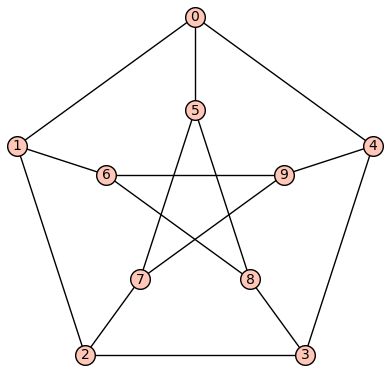

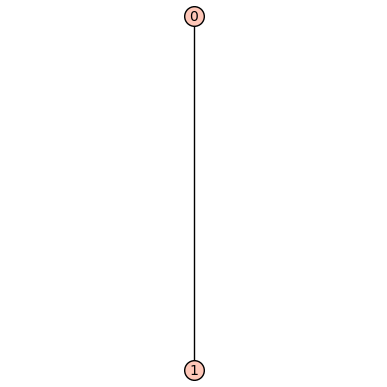

True

In [6]:
def has_minor(G, H):
    try:
        m = G.minor(H)
        return True
    except MIPSolverException:
        return False

G = graphs.PetersenGraph()
H = graphs.CompleteGraph(2)

G.show()
H.show()

has_minor(G, H)

In [9]:
minimals_dict = read_minor_minimals()

In [10]:
g6_str = G.canonical_label().graph6_string()

for spec_key in minimals_dict.keys():
    for H_str in minimals_dict.get(spec_key):
        if has_minor(G, Graph(H_str)):
            print(spec_key, H_str, f'is a minor of {G.graph6_string()}')
            break

0_spectators @ is a minor of IheA@GUAo
1_spectators Bw is a minor of IheA@GUAo
2_spectators E@UW is a minor of IheA@GUAo
3_spectators E?Bw is a minor of IheA@GUAo
4_spectators F@O^G is a minor of IheA@GUAo


NameError: name 'MIPSolverException' is not defined

In [4]:
get_partial_uspcm_dict(6, 10)

{'6_verts': {'10_edges': {'EJ\\w': 3,
   'EB^w': 3,
   'EJ]w': 3,
   'E@~w': 4,
   'EBnw': 3,
   'EInw': 3,
   'EB~o': 4,
   'EJmw': 3,
   'EK^w': 3,
   'EJnW': 3,
   'ER^W': 3,
   'Es\\w': 4,
   'EK~o': 4,
   'ELrw': 4,
   'Ek]w': 4}}}

In [5]:
type('IheA@GUAo')

<class 'str'>

In [61]:
def get_spectator_floor(graph, uspcm_dict=None):
    """INPUT: graph: A graph, graph6_string, or adjacency matrix for a connected graph on at most 10 vertices
uspcm_dict: A dictionary of spectator floor numbers, either the complete dictionary or partial dictionary with
the spectator floor numbers for graphs on the number of vertices and edges that the graph argument has.
OUTPUT: The spectator floor number of the graph.
    """
    G, g6_str = get_canonical_graph(graph)
        
    if G.num_verts() > 10 or G.is_connected() == False:
        return "This function only works for connected graphs on at most 10 vertices"

    num_verts = G.num_verts()
    num_edges = G.num_edges()
    
    if uspcm_dict is None:
        uspcm_dict = get_partial_uspcm_dict(num_verts, num_edges)

    return uspcm_dict[f'{num_verts}_verts'][f'{num_edges}_edges'][g6_str]

In [40]:
G = Graph('IheA@GUAo')
nn = G.num_verts()
ee = G.num_edges()
uspcm_dict = get_partial_uspcm_dict(nn, ee)

In [35]:
get_spectator_floor(graphs.CompleteGraph(11))

'This function only works for connected graphs on at most 10 vertices'

In [45]:

g6_str = Graph('IheA@GUAo').canonical_label().graph6_string()
uspcm_dict[f'{nn}_verts'][f'{ee}_edges'][g6_str]

7

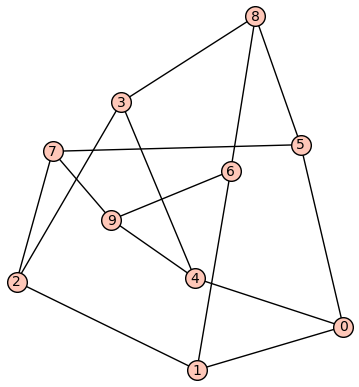

I@OZCMgs?


7

In [54]:
get_spectator_floor('IheA@GUAo', uspcm_dict)

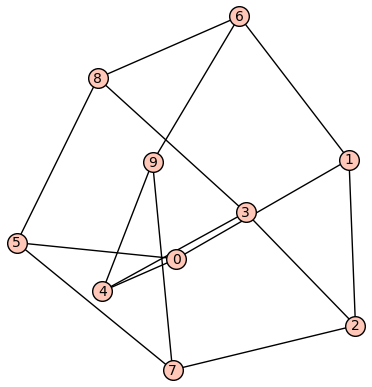

I@OZCMgs?


7

In [56]:
get_spectator_floor('IheA@GUAo')

In [90]:
def get_canonical_graph(graph):
    try:
        mat = Matrix(graph)
        G = Graph(mat)
        g6_str = G.canonical_label().graph6_string()
    except TypeError:
        if type(graph) == str:
            G = Graph(graph)
            g6_str = G.canonical_label().graph6_string()
        elif type(graph) == Graph:
            G = graph
            g6_str = G.canonical_label().graph6_string()
            
    return G, g6_str

        

def has_minor(G, H):
    """Determines if graph H is a minor of graph G"""
    g,_ = get_canonical_graph(G)
    h,_ = get_canonical_graph(H)
            
    try:
        m = g.minor(h)
        return True
    except:
        return False
    
    

def find_minimal_representation(graph, uspcm_dict=None, minimals_dict=None):
    """INPUT: graph: A graph, graph6_string, or adjacency matrix for a connected graph on at most 10 vertices
uspcm_dict: A dictionary of spectator floor numbers, either the complete dictionary or partial dictionary with
the spectator floor numbers for graphs on the number of vertices and edges that the graph argument has.
OUTPUT: The spectator floor number of the graph.
    """
    G, g6_str = get_canonical_graph(graph)
        
    if G.num_verts() > 10 or G.is_connected() == False:
        return "This function only works for connected graphs on at most 10 vertices"

    num_verts = G.num_verts()
    num_edges = G.num_edges()
        
    G_spec_floor = get_spectator_floor(g6_str, uspcm_dict)
    
    if minimals_dict is None:
        minimals_dict = read_minor_minimals()
    
    if g6_str in minimals_dict[f'{G_spec_floor}_spectators']:
        print(f'{graph} is minor-minimal, the canonical labelling of {graph} has graph6_string of {g6_str}')
        if type(graph) == Graph:
            graph.show(title = f'G: {g6_str}, spec_floor = {G_spec_floor}')
        else:
            G.show(title = f'G: {g6_str}, spec_floor = {G_spec_floor}')
        return g6_str
    for H_str in minimals_dict[f'{G_spec_floor}_spectators']:
        if has_minor(G, H_str):
            print(f'{H_str} is a minor of {graph}, both have spectator floor of {G_spec_floor}, so {graph} is NOT minor-minimal')
            ga = graphics_array((G.plot(title = f'G: {g6_str}, spec_floor = {G_spec_floor}'),
                                Graph(H_str).plot(title = f'H: {H_str}, spec_floor = {G_spec_floor}')))
            ga.show()
            return H_str

GBq~V_ is a minor of Complete graph, both have spectator floor of 6, so Complete graph is NOT minor-minimal


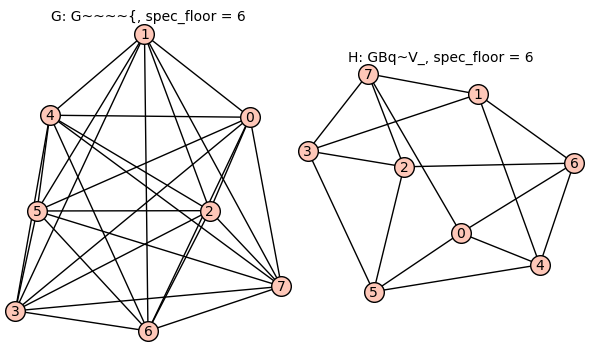

'GBq~V_'

In [92]:
find_minimal_representation(graphs.CompleteGraph(8))

IheA@GUAo is minor-minimal, the canonical labelling of IheA@GUAo has graph6_string of I@OZCMgs?


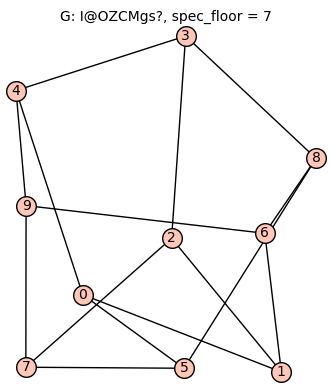

'I@OZCMgs?'

In [91]:
find_minimal_representation('IheA@GUAo')

Petersen graph is minor-minimal, the canonical labelling of Petersen graph has graph6_string of I@OZCMgs?


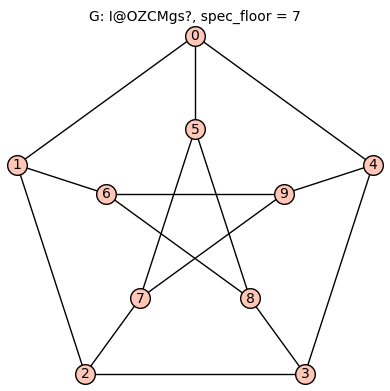

'I@OZCMgs?'

In [93]:
find_minimal_representation(graphs.PetersenGraph())